In [1]:
# ====================================================================
# 1. IMPORT LIBRARIES AND SETUP
# ====================================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = 128  # Keep original size
BATCH_SIZE = 32
EPOCHS = 30

In [2]:
# ====================================================================
# 2. ENHANCED DATA LOADING AND PREPROCESSING
# ====================================================================
def load_enhanced_data(data_dir, max_samples=None):
    """Enhanced data loading with better preprocessing"""
    images = []
    labels = []
    categories = ['not_fractured', 'fractured']
    
    for category_idx, category in enumerate(categories):
        path = os.path.join(data_dir, category)
        if not os.path.exists(path):
            print(f"Warning: Path {path} does not exist")
            continue
            
        image_files = os.listdir(path)
        if max_samples:
            image_files = image_files[:max_samples]
        
        for img_file in image_files:
            try:
                img_path = os.path.join(path, img_file)
                
                # Read image
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_array is None:
                    continue
                
                # Resize with better interpolation
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), 
                                     interpolation=cv2.INTER_AREA)
                
                # Apply CLAHE for better contrast
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                img_array = clahe.apply(img_array)
                
                # Normalize
                img_array = img_array.astype('float32') / 255.0
                
                images.append(img_array)
                labels.append(category_idx)
                
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
                continue
    
    return np.array(images), np.array(labels)

# Load data
print("Loading training data...")
X_train, y_train = load_enhanced_data('BoneFractureDataset/training')
print("Loading testing data...")
X_test, y_test = load_enhanced_data('BoneFractureDataset/testing')

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Check class distribution
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)
print(f"Train class distribution: Not Fractured={train_counts[0]}, Fractured={train_counts[1]}")
print(f"Test class distribution: Not Fractured={test_counts[0]}, Fractured={test_counts[1]}")

# Split training data further for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Loading training data...
Loading testing data...
Training samples: 7091
Testing samples: 600
Train class distribution: Not Fractured=3507, Fractured=3584
Test class distribution: Not Fractured=240, Fractured=360
Train: 5672, Validation: 1419, Test: 600


In [3]:
# ====================================================================
# 3. ENHANCED CNN MODEL (Basic but improved)
# ====================================================================
print("\n" + "="*50)
print("TRAINING ENHANCED CNN MODEL")
print("="*50)

# Reshape data for CNN
X_train_cnn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val_cnn = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test_cnn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Create enhanced CNN model
cnn_model = models.Sequential([
    # First Conv Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Second Conv Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Third Conv Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training CNN...")
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate CNN
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"CNN Test Accuracy: {cnn_acc:.4f}")


TRAINING ENHANCED CNN MODEL


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,710,241 (33.23 MB)

 Trainable params: 8,709,281 (33.22 MB)

 Non-trainable params: 960 (3.75 KB)

Training CNN...
Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.6904 - loss: 0.5987 - val_accuracy: 0.5053 - val_loss: 0.9622
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.8362 - loss: 0.3646 - val_accuracy: 0.5039 - val_loss: 1.4220
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9147 - loss: 0.2276 - val_accuracy: 0.8118 - val_loss: 0.4069
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 1887s 11s/step - accuracy: 0.9445 - loss: 0.1510 - val_accuracy: 0.9662 - val_loss: 0.1046
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.9594 - loss: 0.1036 - val_accuracy: 0.9563 - val_loss: 0.1187
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9757 - loss: 0.0658 - val_accuracy: 0.9704 - val_loss: 0.0938
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.9766 - loss: 0.0657 - val_accuracy: 0.9894 - val_loss: 0.0377
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9880 - loss:

In [4]:
# ====================================================================
# 4. ENHANCED ANN MODEL
# ====================================================================
print("\n" + "="*50)
print("TRAINING ENHANCED ANN MODEL")
print("="*50)

# Create enhanced ANN model
ann_model = models.Sequential([
    layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

ann_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ann_model.summary()

print("Training ANN...")
ann_history = ann_model.fit(
    X_train_cnn, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate ANN
ann_loss, ann_acc = ann_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"ANN Test Accuracy: {ann_acc:.4f}")


TRAINING ENHANCED ANN MODEL


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,564,737 (32.67 MB)

 Trainable params: 8,563,201 (32.67 MB)

 Non-trainable params: 1,536 (6.00 KB)

Training ANN...
Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.6446 - loss: 0.6326 - val_accuracy: 0.7005 - val_loss: 0.6174
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.7533 - loss: 0.5003 - val_accuracy: 0.8027 - val_loss: 0.4440
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.8140 - loss: 0.4041 - val_accuracy: 0.8041 - val_loss: 0.4307
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.8498 - loss: 0.3361 - val_accuracy: 0.7865 - val_loss: 0.5856
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - accuracy: 0.8833 - loss: 0.2856 - val_accuracy: 0.8640 - val_loss: 0.2867
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.8951 - loss: 0.2555 - val_accuracy: 0.8492 - val_loss: 0.3176
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.9060 - loss: 0.2321 - val_accuracy: 0.8478 - val_loss: 0.3383
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 

In [5]:
# ====================================================================
# 5. ENHANCED SVM MODEL
# ====================================================================
print("\n" + "="*50)
print("TRAINING ENHANCED SVM MODEL")
print("="*50)

# Flatten images
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Check class balance
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class distribution in training: {dict(zip(['Not Fractured', 'Fractured'], counts))}")

# For SVM, we'll use a subset but ensure class balance
n_samples_per_class = min(2000, min(counts))
print(f"Using {n_samples_per_class} samples per class for SVM training")

# Balance the training data
idx_class0 = np.where(y_train == 0)[0][:n_samples_per_class]
idx_class1 = np.where(y_train == 1)[0][:n_samples_per_class]

svm_indices = np.concatenate([idx_class0, idx_class1])
np.random.shuffle(svm_indices)

X_train_svm = X_train_scaled[svm_indices]
y_train_svm = y_train[svm_indices]

# Train SVM with better parameters
print("Training SVM...")
svm_model = SVC(
    kernel='rbf',  # Changed from linear to rbf for better performance
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

svm_model.fit(X_train_svm, y_train_svm)

# Predict on validation first to check performance
svm_val_preds = svm_model.predict(X_val_scaled)
svm_val_acc = accuracy_score(y_val, svm_val_preds)
print(f"SVM Validation Accuracy: {svm_val_acc:.4f}")

# Predict on test
svm_preds = svm_model.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_preds)
print(f"SVM Test Accuracy: {svm_acc:.4f}")


TRAINING ENHANCED SVM MODEL
Class distribution in training: {'Not Fractured': np.int64(2805), 'Fractured': np.int64(2867)}
Using 2000 samples per class for SVM training
Training SVM...
SVM Validation Accuracy: 0.9316
SVM Test Accuracy: 0.7733


In [6]:
# ====================================================================
# 6. ENHANCED RANDOM FOREST MODEL
# ====================================================================
print("\n" + "="*50)
print("TRAINING ENHANCED RANDOM FOREST MODEL")
print("="*50)

# For Random Forest, we can use more data
n_rf_samples = min(4000, len(X_train_scaled))
print(f"Using {n_rf_samples} samples for Random Forest training")

# Create balanced subset for RF
rf_class0_idx = np.where(y_train == 0)[0][:n_rf_samples//2]
rf_class1_idx = np.where(y_train == 1)[0][:n_rf_samples//2]
rf_indices = np.concatenate([rf_class0_idx, rf_class1_idx])
np.random.shuffle(rf_indices)

X_train_rf = X_train_scaled[rf_indices]
y_train_rf = y_train[rf_indices]

# Train Random Forest with better parameters
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,  # Increased from 100
    max_depth=20,      # Limit depth to prevent overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train_rf, y_train_rf)

# Predict on validation
rf_val_preds = rf_model.predict(X_val_scaled)
rf_val_acc = accuracy_score(y_val, rf_val_preds)
print(f"Random Forest Validation Accuracy: {rf_val_acc:.4f}")

# Predict on test
rf_preds = rf_model.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_preds)
print(f"Random Forest Test Accuracy: {rf_acc:.4f}")



TRAINING ENHANCED RANDOM FOREST MODEL
Using 4000 samples for Random Forest training
Training Random Forest...
Random Forest Validation Accuracy: 0.9725
Random Forest Test Accuracy: 0.7200



RESULTS COMPARISON
Model           Accuracy  
-------------------------
CNN             0.6800
ANN             0.5417
SVM             0.7733
Random Forest   0.7200

DETAILED CLASSIFICATION REPORTS

CNN Classification Report:
----------------------------------------
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step
               precision    recall  f1-score   support

Not Fractured       0.60      0.58      0.59       240
    Fractured       0.73      0.75      0.74       360

     accuracy                           0.68       600
    macro avg       0.67      0.66      0.66       600
 weighted avg       0.68      0.68      0.68       600


ANN Classification Report:
----------------------------------------
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
               precision    recall  f1-score   support

Not Fractured       0.47      0.99      0.63       240
    Fractured       0.98      0.24      0.39       360

     accuracy                           0.54       600
    macro avg       0.72     

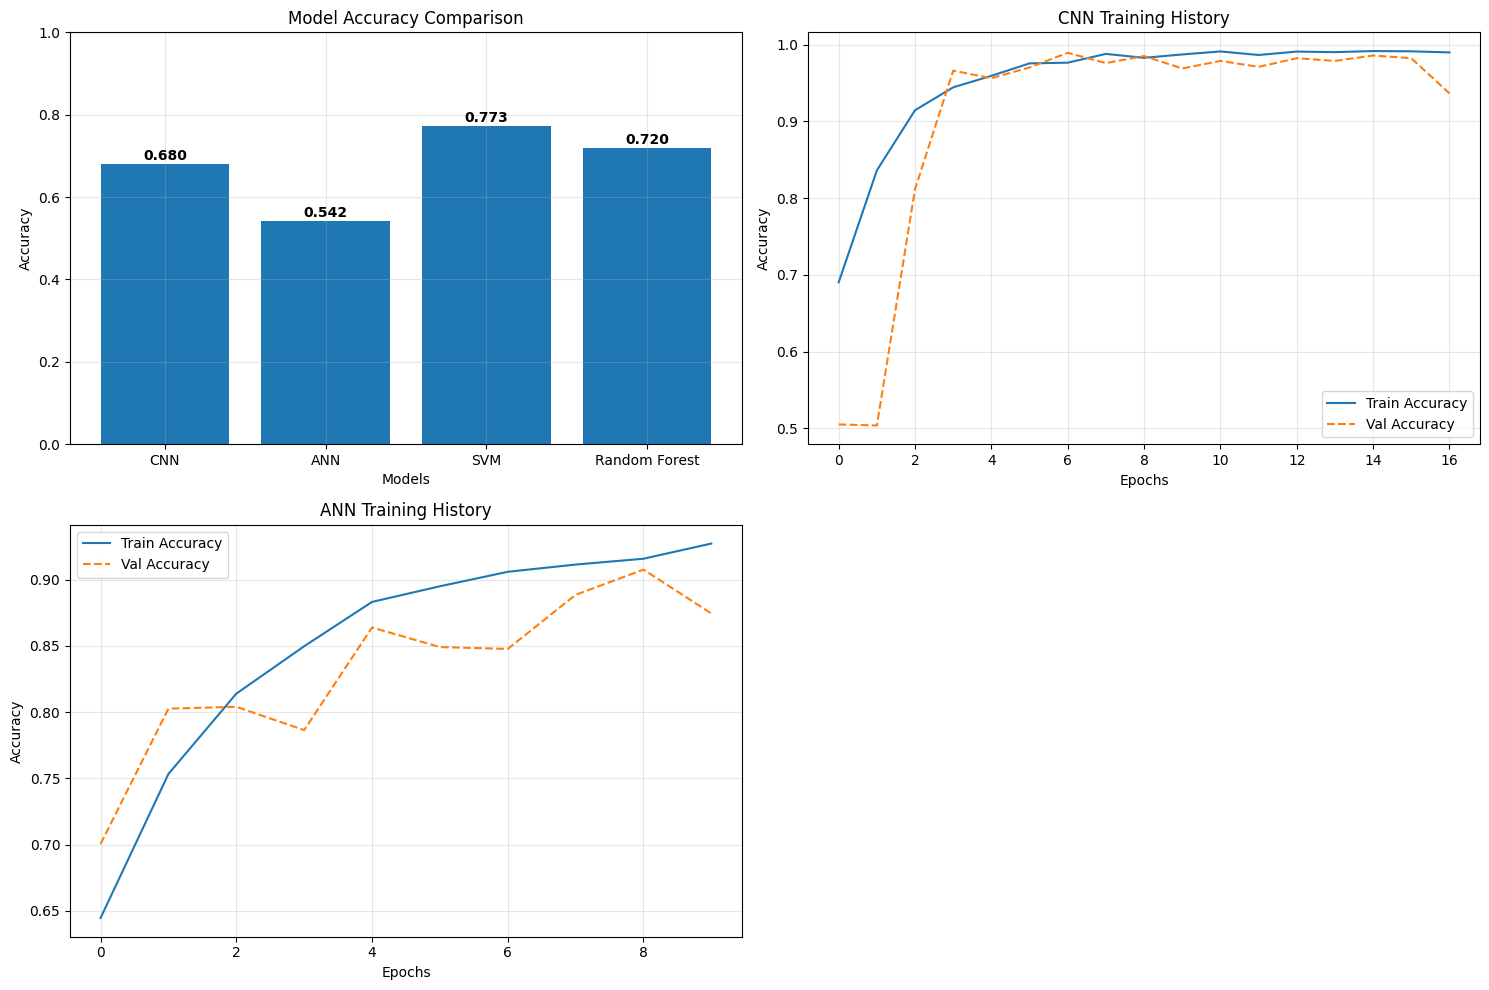

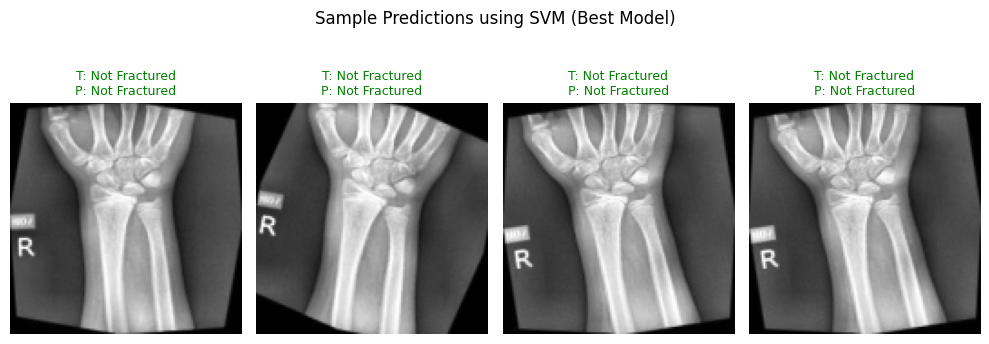

In [8]:
# ====================================================================
# 7. RESULTS COMPARISON AND VISUALIZATION (FULL CORRECT CELL)
# ====================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("\n" + "="*50)
print("RESULTS COMPARISON")
print("="*50)

# Collect accuracies
models_names = ['CNN', 'ANN', 'SVM', 'Random Forest']
accuracies = [cnn_acc, ann_acc, svm_acc, rf_acc]

# Display comparison table
print(f"{'Model':<15} {'Accuracy':<10}")
print("-" * 25)
for name, acc in zip(models_names, accuracies):
    print(f"{name:<15} {acc:.4f}")

# ====================================================================
# DETAILED CLASSIFICATION REPORTS
# ====================================================================
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORTS")
print("="*50)

for name, model, X_data in [
    ('CNN', cnn_model, X_test_cnn),
    ('ANN', ann_model, X_test_cnn),
    ('SVM', svm_model, X_test_scaled),
    ('Random Forest', rf_model, X_test_scaled)
]:
    print(f"\n{name} Classification Report:")
    print("-" * 40)

    if name in ['CNN', 'ANN']:
        y_pred = (model.predict(X_data) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_data)

    print(classification_report(
        y_test, y_pred,
        target_names=['Not Fractured', 'Fractured']
    ))

# ====================================================================
# FIGURE 1: ACCURACY + TRAINING HISTORY
# ====================================================================
plt.figure(figsize=(15, 10))

# 1. Accuracy Comparison
plt.subplot(2, 2, 1)
plt.bar(models_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.grid(True, alpha=0.3)

# 2. CNN Training History
plt.subplot(2, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. ANN Training History
plt.subplot(2, 2, 3)
plt.plot(ann_history.history['accuracy'], label='Train Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ANN Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ====================================================================
# FIGURE 2: SAMPLE PREDICTIONS (BEST MODEL)
# ====================================================================
plt.figure(figsize=(10, 4))

best_model_idx = np.argmax(accuracies)
best_model_name = models_names[best_model_idx]

if best_model_name == 'CNN':
    predictions = (cnn_model.predict(X_test_cnn[:4]) > 0.5).astype(int).flatten()
elif best_model_name == 'ANN':
    predictions = (ann_model.predict(X_test_cnn[:4]) > 0.5).astype(int).flatten()
elif best_model_name == 'SVM':
    predictions = svm_model.predict(X_test_scaled[:4])
else:
    predictions = rf_model.predict(X_test_scaled[:4])

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X_test[i], cmap='gray')
    true_label = 'Fractured' if y_test[i] == 1 else 'Not Fractured'
    pred_label = 'Fractured' if predictions[i] == 1 else 'Not Fractured'
    color = 'green' if y_test[i] == predictions[i] else 'red'
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=9, color=color)
    plt.axis('off')

plt.suptitle(f'Sample Predictions using {best_model_name} (Best Model)', fontsize=12)
plt.tight_layout()
plt.show()



CONFUSION MATRICES
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


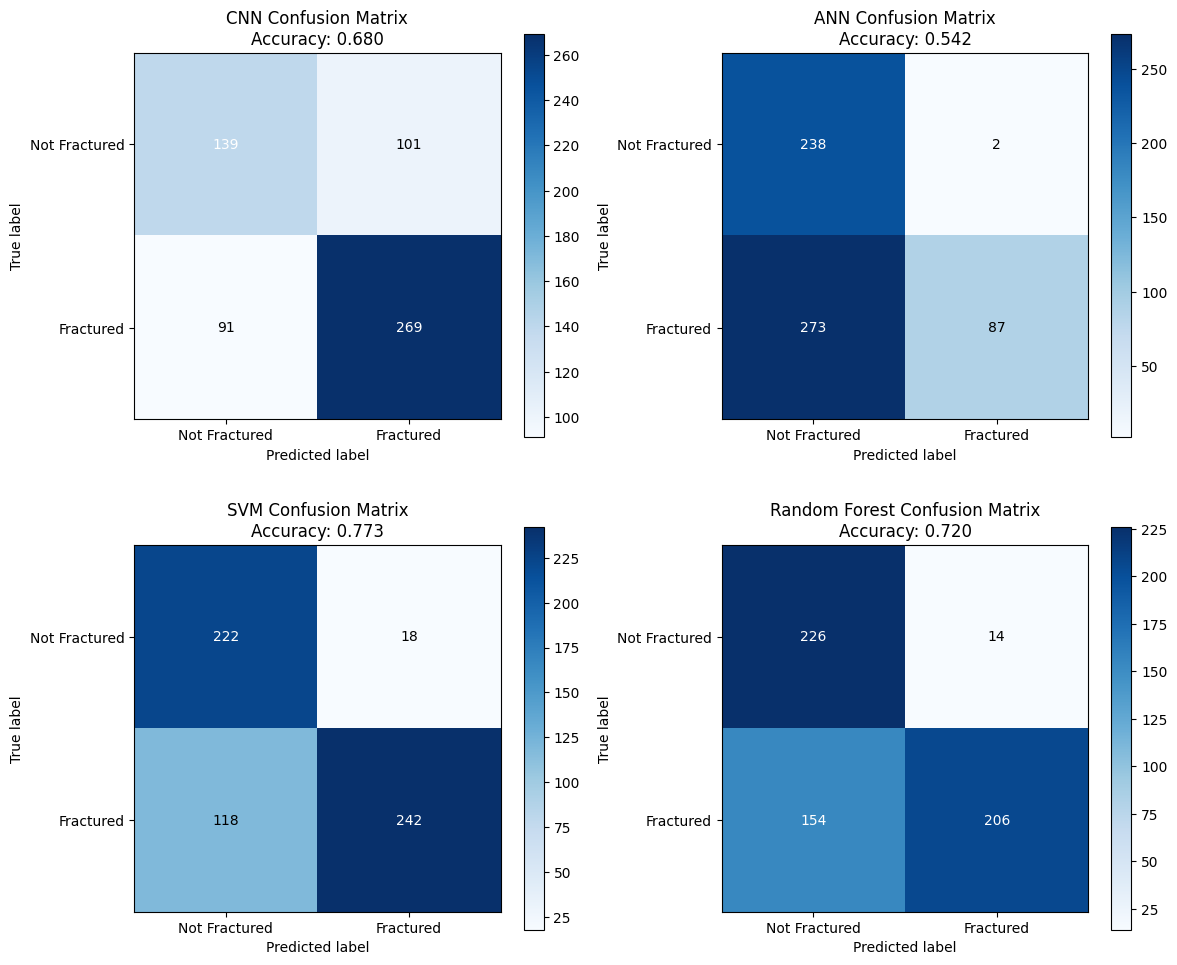

In [9]:
# ====================================================================
# 8. CONFUSION MATRICES
# ====================================================================
print("\n" + "="*50)
print("CONFUSION MATRICES")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, (name, model, X_data) in enumerate([('CNN', cnn_model, X_test_cnn),
                                             ('ANN', ann_model, X_test_cnn),
                                             ('SVM', svm_model, X_test_scaled),
                                             ('Random Forest', rf_model, X_test_scaled)]):
    ax = axes[idx // 2, idx % 2]
    
    if name in ['CNN', 'ANN']:
        y_pred_proba = model.predict(X_data)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    else:
        y_pred = model.predict(X_data)
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Set labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['Not Fractured', 'Fractured'],
           yticklabels=['Not Fractured', 'Fractured'],
           title=f'{name} Confusion Matrix\nAccuracy: {accuracies[idx]:.3f}',
           ylabel='True label',
           xlabel='Predicted label')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [10]:
# ====================================================================
# 9. SAVE MODELS
# ====================================================================
print("\n" + "="*50)
print("SAVING MODELS")
print("="*50)

# Save TensorFlow models
cnn_model.save('cnn_bone_fracture.h5')
ann_model.save('ann_bone_fracture.h5')
print("CNN and ANN models saved.")

# Save scikit-learn models
import joblib
joblib.dump(svm_model, 'svm_bone_fracture.pkl')
joblib.dump(rf_model, 'rf_bone_fracture.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("SVM, Random Forest models and scaler saved.")

print("\n" + "="*50)
print("PROJECT COMPLETE")
print("="*50)
print(f"Best model: {models_names[np.argmax(accuracies)]} with accuracy: {max(accuracies):.4f}")


SAVING MODELS


CNN and ANN models saved.
SVM, Random Forest models and scaler saved.

PROJECT COMPLETE
Best model: SVM with accuracy: 0.7733
